# Execute always to load the data

In [ ]:
from pathlib import Path
import numpy as np
import torch
from tools.import_utils import load_config
from tools.scripts_utils import generate_g2m_dataset_from_paths, get_model_dataset, init_mace_g2m_model
from tools.tools import get_basis_from_structures_paths, load_model
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import warnings
import sisl
from tools.debug import create_sparse_matrix
from joblib import dump, load

from graph2mat import (
    BasisTableWithEdges,
)

Load all data

In [ ]:
debug_mode = False
# *********************************** #
# * VARIABLES TO CHANGE BY THE USER * #
# *********************************** #
model_dir = Path("../results/h_crystalls_1") # Results directory
filename = "train_best_model.tar" # Model name (or relative path to the results directory)
compute_calculations = False # Save or Load calculations.

# *********************************** #

# Hide some warnings
warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")
if debug_mode:
    print("**************************************************")
    print("*                                                *")
    print("*              DEBUG MODE ACTIVATED              *")
    print("*                                                *")
    print("**************************************************")

savedir = model_dir / "results"
savedir.mkdir(exist_ok=True, parents=True)
calculations_path = savedir / "alldataset/calculations_alldataset.joblib"

# Define orbital labels (for now we will assume that all atoms have the same orbitals). Use the same order as appearance in the hamiltonian.
orbitals = {
    0: "s1",
    1: "s2",
    2: "py1",
    3: "pz1",
    4: "px1",
    5: "py2",
    6: "pz2",
    7: "px2",
    8: "Pdxy",
    9: "Pdyz",
    10: "Pdz2",
    11: "Pdxz",
    12: "Pdx2-y2",
}
n_orbs = len(orbitals)

# Load the config of the model
config = load_config(model_dir / "config.yaml")
device = torch.device("cpu")

# Load the same dataset used to train/validate the model (paths)
train_paths, val_paths = get_model_dataset(model_dir, verbose=True)

# Load the results
print("Loading the results...")
try:
    data = load(calculations_path)
    print("Results loaded!")
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find the saved calculations at {calculations_path}")

# Reconstruct your tuples and labels
train_data   = (data['train_true'],   data['train_pred'])
val_data     = (data['val_true'],     data['val_pred'])
train_labels = data['train_labels']
val_labels   = data['val_labels']


# Unpack for clarity
train_true, train_pred = train_data
val_true,   val_pred   = val_data

# Means
train_means = (
    np.array([m.mean() for m in train_true]),
    np.array([m.mean() for m in train_pred])
)
val_means = (
    np.array([m.mean() for m in val_true]),
    np.array([m.mean() for m in val_pred])
)

# Standard deviations (ddof=1)
train_stds = (
    np.array([np.std(m.toarray(), ddof=0) for m in train_true]),
    np.array([np.std(m.toarray(), ddof=0) for m in train_pred])
)
val_stds = (
    np.array([np.std(m.toarray(), ddof=0) for m in val_true]),
    np.array([np.std(m.toarray(), ddof=0) for m in val_pred])
)

# Max absolute error
maxae_train = np.array([
    np.max(np.abs(t - p))
    for t, p in zip(train_true, train_pred)
])
maxae_val = np.array([
    np.max(np.abs(t - p))
    for t, p in zip(val_true, val_pred)
])

maxaes = ([maxae_train, maxae_val])
labels = ([path.parts[-2][14:] +"/"+ path.parts[-1] for path in train_paths], [path.parts[-2][14:] +"/"+ path.parts[-1] for path in val_paths])

colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # medium gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#fdae61',  # sandy orange
    '#66c2a5',  # seafoam green
    '#fc8d62',  # coral
    '#a6d854',  # light lime
    '#ffd92f',  # sunflower
    '#e5c494',  # beige
    '#b3b3b3'   # soft gray
]

# Blablabla

In [ ]:
import plotly.graph_objects as go

def plot_dataset_results(
        train_data, val_data,
        colors, title,
        train_labels, val_labels,
        train_means, val_means,
        train_stds, val_stds,
        maxaes, maxaes_labels,
        filepath
):
    fig = go.Figure()
    n_train_samples = len(train_data[0])
    n_val_samples = len(val_data[0])

    train_data = [[train_data[k][i].data for i in range(n_train_samples)] for k in range(len(train_data))]
    val_data = [[val_data[k][i].data for i in range(n_val_samples)] for k in range(len(val_data))]
    

    # ====== TRAINING DATA ======
    matrix_traces = []
    mean_traces = []
    std_traces = []
    for i in range(n_train_samples):
        # Training matrix elements
        # print("It", i)
        # print("True=",train_data[0][i])
        # print("Pred=",train_data[1][i])
        trace = go.Scatter(
            x=train_data[0][i],
            y=train_data[1][i],
            mode='markers',
            marker=dict(
                # symbol='dash',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=0)
            ),
            name=f'Training sample {i}',
            text=train_labels[i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='training',
            # legendgrouptitle="Training samples",
            showlegend=True
        )
        matrix_traces.append(trace)

        # Training means
        trace = go.Scatter(
            x=[train_means[0][i]],
            y=[train_means[1][i]],
            mode='markers',
            marker=dict(
                symbol='square',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=0)
            ),
            name=f'Mean training {i}',
            text=maxaes_labels[0][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='training_mean',
            visible=False,
            showlegend=True,
        )
        mean_traces.append(trace)

        # Training std
        trace = go.Scatter(
            x=[train_stds[0][i]],
            y=[train_stds[1][i]],
            mode='markers',
            marker=dict(
                symbol='triangle-up',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=0)
            ),
            name=f'Std training {i}',
            text=maxaes_labels[0][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='training_std',
            visible=False,
            showlegend=True,
        )
        std_traces.append(trace)

    # === Validation ===
    for i in range(n_val_samples):
        trace = go.Scatter(
            x=val_data[0][i],
            y=val_data[1][i],
            mode='markers',
            marker=dict(
                symbol='circle-open',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=1,)
            ),
            name=f'Validation sample {i}',
            text=val_labels[i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='validation',
            # legendgrouptitle="Validation samples",
            showlegend=True
        )
        matrix_traces.append(trace)

        # Val means
        trace = go.Scatter(
            x=[val_means[0][i]],
            y=[val_means[1][i]],
            mode='markers',
            marker=dict(
                symbol='square-open',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=1,)
            ),
            name=f'Mean val {i}',
            text=maxaes_labels[1][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='val_mean',
            visible=False,
            showlegend=True,
        )
        mean_traces.append(trace)

        # Validation std
        trace = go.Scatter(
            x=[val_stds[0][i]],
            y=[val_stds[1][i]],
            mode='markers',
            marker=dict(
                symbol='triangle-up-open',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=0)
            ),
            name=f'Std validation {i}',
            text=maxaes_labels[1][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='val_std',
            visible=False,
            showlegend=True,
        )
        std_traces.append(trace)
        


    # Add identity line
    train_flattened_data = ([np.min(train_data[0][i]) for i in range(n_train_samples)], [np.max(train_data[0][i]) for i in range(n_val_samples)]) # [min, max]
    # print((train_flattened_data[0]))
    train_flattened_data = [train_flattened_data[k] for k in range(len(train_flattened_data))]
    # print(len(train_flattened_data))

    min, max = np.min(train_flattened_data[0]), np.max(train_flattened_data[1])
    diagonal_trace = go.Scatter(
        x=[min, max],
        y=[min, max],
        mode='lines',
        line=dict(color='black', dash='solid'),
        name='Ideal'
    )


    # Last dropdown: Max Absolute error
    error_trace_train = go.Scatter(
        x=maxaes[0],
        y=maxaes_labels[0],
        mode='markers',
        marker=dict(
            symbol='x',
            size=6,
            color="blue"
        ),
        name='Training',
        showlegend=False  # optional: hide legend for this simple plot
    )
    # Last dropdown: Max Absolute error
    error_trace_val = go.Scatter(
        x=maxaes[1],
        y=maxaes_labels[1],
        mode='markers',
        marker=dict(
            symbol='x',
            size=6,
            color="red"
        ),
        name='Validation',
        showlegend=False  # optional: hide legend for this simple plot
    )
    # zero_line_trace = go.Scatter(
    #     x=[0, 0],
    #     y=[maxaes_labels[1][-1], maxaes_labels[0][-1]],  # or your preferred Y range
    #     mode='lines',
    #     line=dict(color='black', dash='dash'),
    #     name='zero',
    #     showlegend=False
    # )






    # Create figure and update layout
    traces = matrix_traces + mean_traces + std_traces + [error_trace_train] + [error_trace_val] + [diagonal_trace]
    fig = go.Figure(data=traces)
    fig.update_layout(
        width=1000,
        height=1000,
        title=title,
        # xaxis_title='True Values',
        # yaxis_title='Predicted Values',
        legend_title='Legend',
        # hovermode='closest',
        # template='plotly_white',
        xaxis=dict(
            title='True Values',
            tickformat=".2f"
        ),
        yaxis=dict(
            title='Predicted Values',
            tickformat=".2f"
        )
    )

    # Add dropdown
    data_true = np.concatenate(train_data[0] + val_data[0], axis=0)
    data_pred = np.concatenate(train_data[1] + val_data[1], axis=0)
    min_x_data = data_true.min()
    max_x_data = data_true.max()
    min_y_data = data_pred.min()
    max_y_data = data_pred.max()

    min_x_mean = np.min([train_means[0].min(), val_means[0].min()])
    max_x_mean = np.max([train_means[0].max(), val_means[0].max()])
    min_y_mean = np.min([train_means[1].min(), val_means[1].min()])
    max_y_mean = np.max([train_means[1].max(), val_means[1].max()])

    min_x_std = np.min([train_stds[0].min(), val_stds[0].min()])
    max_x_std = np.max([train_stds[0].max(), val_stds[0].max()])
    min_y_std = np.min([train_stds[1].min(), val_stds[1].min()])
    max_y_std = np.max([train_stds[1].max(), val_stds[1].max()])

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=[
                    dict(
                        label="SISL Hamiltonian elements",
                        method="update",
                        args=[{"visible": [True]*len(matrix_traces) + [False]*len(mean_traces) + [False]*len(std_traces) + [False]*2 + [True]},
                            {
                                "xaxis": {"range": [min_x_data-0.05*min_x_data, max_x_data+0.05*max_x_data]},
                                "yaxis": {"range": [min_y_data-0.05*min_y_data, max_y_data+0.05*max_y_data]},
                            }]
                    ),
                    dict(
                        label="Mean",
                        method="update",
                        args=[
                            {"visible": [False]*len(matrix_traces) + [True]*len(mean_traces) + [False]*len(std_traces) + [False]*2 + [True]},
                            {
                                "xaxis": {"range": [min_x_mean-0.0005*min_x_mean, max_x_mean+0.0005*max_x_mean]},
                                "yaxis": {"range": [min_y_mean-0.0005*min_y_mean, max_y_mean+0.0005*max_y_mean]},
                            }

                        ]
                    ),
                    dict(
                        label="Std",
                        method="update",
                        args=[
                            {"visible": [False]*len(matrix_traces) + [False]*len(mean_traces) + [True]*len(std_traces) + [False]*2 + [True]},
                            {
                                "xaxis": {"range": [min_x_std-0.0005*min_x_std, max_x_std+0.0005*max_x_std]},
                                "yaxis": {"range": [min_y_std-0.0005*min_y_std, max_y_std+0.0005*max_y_std]},
                            }

                        ]
                    ),
                    dict(
                        label="Max Absolute Error",
                        method="update",
                        args=[
                            {"visible": [False]*len(matrix_traces) + [False]*len(mean_traces) + [False]*len(std_traces) + [True]*2 + [False]},
                            {"xaxis": {"title": "Max Absolute Error"},
                            "yaxis": {
                                "title": "Structures",
                                "type": "category",
                                #  "categoryorder": "array",
                                "categoryarray": maxaes_labels,
                                "autorange": "reversed"
                            },
                            "showlegend": [False]*len(matrix_traces + mean_traces + std_traces) + [False]*2 + [False]}
                        ]
                    )


                ],
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.3,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    # Save to HTML if path is provided
    if filepath:
        f = open(filepath, "w")
        f.close()
        with open(filepath, 'a') as f:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        f.close()
        
        with open(f"{str(filepath)[:-4]}.json", "w") as f:
            f.write(fig.to_json())

    else:
        fig.show()

    
    return fig

In [ ]:
filepath= savedir / "dataset_analysis.html"
title = f"Dataset analysis. Used model {model_dir.parts[-1]}"
print("Generating results...")
plot_dataset_results(
    train_data=train_data, val_data=val_data,
    colors=colors, title=title,
    train_labels=train_labels, val_labels=val_labels,
    train_means=train_means, val_means=val_means,
    train_stds=train_stds, val_stds=val_stds,
    maxaes=values, maxaes_labels=labels,
    filepath=None
)
print(f"Results saved at {filepath}!")

# Loading the json

In [ ]:
import plotly.io as pio
fig = pio.read_json(savedir / "dataset_analysis..json")
fig.show()

# Testing to plot only matrix elements

In [ ]:
import plotly.graph_objects as go
    
def plot_diagonal(
    true_values, pred_values, labels, # 1D array of elements.
    title="Default title", title_x="X axis", title_y="Y axis", colors=None,
    filepath=None
):
    # Define default values
    # if colors is None:
    #     colors = [
    #         '#1f77b4',  # muted blue
    #         '#ff7f0e',  # safety orange
    #         '#2ca02c',  # cooked asparagus green
    #         '#d62728',  # brick red
    #         '#9467bd',  # muted purple
    #         '#8c564b',  # chestnut brown
    #         '#e377c2',  # raspberry yogurt pink
    #         '#7f7f7f',  # medium gray
    #         '#bcbd22',  # curry yellow-green
    #         '#17becf',  # blue-teal
    #         '#fdae61',  # sandy orange
    #         '#66c2a5',  # seafoam green
    #         '#fc8d62',  # coral
    #         '#a6d854',  # light lime
    #         '#ffd92f',  # sunflower
    #         '#e5c494',  # beige
    #         '#b3b3b3'   # soft gray
    #     ]


    fig = go.Figure()
    
    # ====== TRAINING DATA ======
    traces = []
    # Training matrix elements
    trace = go.Scattergl(
        x=true_values,
        y=pred_values,
        mode='markers',
        marker=dict(
            # symbol='dash',
            size=5,
            # color=colors[i % len(colors)],
            line=dict(width=0)
        ),
        name=f'Matrix elements',
        text=labels,
        # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
        # legendgroup='training',
        # legendgrouptitle="Training samples",
        # showlegend=True
    )
    traces.append(trace)
        

    # Add identity line
    all_data = np.concatenate([true_values, pred_values])
    vmin, vmax = np.min(all_data), np.max(all_data)
    diagonal_trace = go.Scatter(
        x=[vmin, vmax],
        y=[vmin, vmax],
        mode='lines',
        line=dict(color='black', dash='dash'),
        name='Ideal'
    )
    traces.append(diagonal_trace)


    # Create figure and update layout
    fig = go.Figure(data=traces)
    fig.update_layout(
        width=900,
        height=900,
        title=title,
        # xaxis_title=title_x,
        # yaxis_title=title_y,
        # legend_title='Legend',
        # hovermode='closest',
        # template='plotly_white',
        xaxis=dict(
            title=title_x,
            tickformat=".2f"
        ),
        yaxis=dict(
            title=title_y,
            tickformat=".2f"
        )
    )

    # Save to HTML if path is provided
    if filepath:
        f = open(filepath, "w")
        f.close()
        with open(filepath, 'a') as f:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        f.close()
        
        with open(f"{str(filepath)[:-4]}.json", "w") as f:
            f.write(fig.to_json())

    else:
        fig.show()


In [ ]:
def plot_pred_vs_true_mean(
        colors, title,
        train_means, val_means,
        train_stds, val_stds,
        labels,
        n_train_samples, n_val_samples=None,
        filepath=None
):

    fig = go.Figure()

    # ====== TRAINING DATA ======
    mean_traces = []
    std_traces = []
    for i in range(n_train_samples):

        # Training means
        trace = go.Scatter(
            x=[train_means[0][i]],
            y=[train_means[1][i]],
            mode='markers',
            marker=dict(
                symbol='square',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=0)
            ),
            name=f'Mean training {i}',
            # text=labels[0][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='training_mean',
            visible=True,
            showlegend=True,
        )
        mean_traces.append(trace)

        # Training std
        trace = go.Scatter(
            x=[train_stds[0][i]],
            y=[train_stds[1][i]],
            mode='markers',
            marker=dict(
                symbol='triangle-up',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=0)
            ),
            name=f'Std training {i}',
            text=labels[0][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='training_std',
            visible=False,
            showlegend=True,
        )
        std_traces.append(trace)

    # === Validation ===
    for i in range(n_val_samples):

        # Val means
        trace = go.Scatter(
            x=[val_means[0][i]],
            y=[val_means[1][i]],
            mode='markers',
            marker=dict(
                symbol='square-open',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=1,)
            ),
            name=f'Mean val {i}',
            text=labels[1][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='val_mean',
            visible=True,
            showlegend=True,
        )
        mean_traces.append(trace)

        # Validation std
        trace = go.Scatter(
            x=[val_stds[0][i]],
            y=[val_stds[1][i]],
            mode='markers',
            marker=dict(
                symbol='triangle-up-open',
                size=5,
                color=colors[i % len(colors)],
                line=dict(width=0)
            ),
            name=f'Std validation {i}',
            text=labels[1][i],
            # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
            legendgroup='val_std',
            visible=False,
            showlegend=True,
        )
        std_traces.append(trace)
        


    # Add identity line
    all_x = np.concatenate([train_means[0], val_means[0],
                            train_stds[0],  val_stds[0]])
    vmin, vmax = all_x.min(), all_x.max()

    # use this for the diagonal
    diagonal_trace = go.Scatter(
        x=[vmin, vmax], y=[vmin, vmax],
        mode='lines', line=dict(color='black'),
        name='Ideal', visible=True, showlegend=True
    )

    # Create figure and update layout
    min_x_mean = np.min([train_means[0].min(), val_means[0].min()])
    max_x_mean = np.max([train_means[0].max(), val_means[0].max()])
    min_y_mean = np.min([train_means[1].min(), val_means[1].min()])
    max_y_mean = np.max([train_means[1].max(), val_means[1].max()])

    min_x_std = np.min([train_stds[0].min(), val_stds[0].min()])
    max_x_std = np.max([train_stds[0].max(), val_stds[0].max()])
    min_y_std = np.min([train_stds[1].min(), val_stds[1].min()])
    max_y_std = np.max([train_stds[1].max(), val_stds[1].max()])

    traces = mean_traces + std_traces + [diagonal_trace]
    fig = go.Figure(data=traces)
    fig.update_layout(
        width=1000,
        height=1000,
        title=title,
        # xaxis_title='True Values',
        # yaxis_title='Predicted Values',
        legend_title='Legend',
        # hovermode='closest',
        # template='plotly_white',
        xaxis=dict(
            title='True Values',
            tickformat=".2f",
            range = [min_x_mean, max_x_mean]
        ),
        yaxis=dict(
            title='Predicted Values',
            tickformat=".2f",
            range = [min_y_mean, max_y_mean]
        )
    )

    # Add dropdown
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=[
                    dict(
                        label="Mean",
                        method="update",
                        args=[
                            {"visible": [True]*len(mean_traces) + [False]*len(std_traces) + [True]},
                            {
                                "xaxis": {"range": [min_x_mean-0.0005*min_x_mean, max_x_mean+0.0005*max_x_mean]},
                                "yaxis": {"range": [min_y_mean-0.0005*min_y_mean, max_y_mean+0.0005*max_y_mean]},
                            }

                        ]
                    ),
                    dict(
                        label="Std",
                        method="update",
                        args=[
                            {"visible": [False]*len(mean_traces) + [True]*len(std_traces) + [True]},
                            {
                                "xaxis": {"range": [min_x_std-0.0005*min_x_std, max_x_std+0.0005*max_x_std]},
                                "yaxis": {"range": [min_y_std-0.0005*min_y_std, max_y_std+0.0005*max_y_std]},
                            }

                        ]
                    ),
                ],
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.75,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    # Save to HTML if path is provided
    if filepath:
        f = open(filepath, "w")
        f.close()
        with open(filepath, 'a') as f:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        f.close()
        
        with open(f"{str(filepath)[:-4]}.json", "w") as f:
            f.write(fig.to_json())

    
    return fig

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_alldataset_struct_vs_scalar(
    title, title_x,
    values_train, labels_train, n_train_samples,
    values_val=None, labels_val=None, n_val_samples=None,
    filepath=None
):
    # 1) Build a master list of unique labels in the order you want them
    all_labels = list(dict.fromkeys(
        labels_train + (labels_val if n_val_samples else [])
    ))

    # 2) Map each label to its integer position
    idx_map = {lab: i for i, lab in enumerate(all_labels)}

    # 3) Convert your y-arrays to numeric
    y_train = [idx_map[l] for l in labels_train]
    y_val   = [idx_map[l] for l in (labels_val if n_val_samples else [])]

    # 4) Build your traces using numeric y
    traces = [
        go.Scatter(
            x=values_train, y=y_train,
            mode='markers',
            marker=dict(symbol='x', size=6, color='blue'),
            name='Training',
            showlegend=True
        )
    ]

    # Dummy trace to show x axis on top
    traces.append(go.Scatter(
        x=[min(values_train), max(values_train)],
        y=[-1, -1],  # Place out of view
        xaxis='x2',
        mode='markers',
        marker=dict(opacity=0),
        visible=True,
        showlegend=False
    ))

    if n_val_samples:
        traces.append(
            go.Scatter(
                x=values_val, y=y_val,
                mode='markers',
                marker=dict(symbol='x', size=6, color='red'),
                name='Validation',
                showlegend=True
            )
        )

    fig = go.Figure(traces)

    # 5) Set the axis so categories sit exactly at integer ticks from 0…N-1
    fig.update_layout(
        width=800,
        height=(n_train_samples + (n_val_samples or 0)) * 15 + 100,
        title={
            'text': title,
            'y':1,
            'x':0.01,
            'xanchor': 'left',
            'yanchor': 'top',
            "pad": dict(t=10),
        },
        yaxis=dict(
            tickmode='array',
            tickvals=list(range(len(all_labels))),
            ticktext=all_labels,
            range=[-0.5, len(all_labels) - 0.5],
            autorange=False
        ),
        xaxis=dict(
            title=title_x,
            title_standoff=0,
            side="bottom",
            showline=True,
            exponentformat='power',   # use 'e' for scientific, 'E' for capital E, or 'power' for 10^x
            showexponent='last',   # always show exponent
        ),
        xaxis2=dict(
            title=title_x,
            title_standoff=0,
            overlaying="x",   # share the same data range as xaxis
            side="top",       # draw it at the top
            exponentformat='power',   # use 'e' for scientific, 'E' for capital E, or 'power' for 10^x
            showexponent='last',   # always show exponent
        ),
        margin=dict(l=40, r=20, t=65, b=45)
    )

    # 6) Save or show
    if filepath:
        fig.write_html(filepath, include_plotlyjs='cdn', full_html=False)
        fig.write_json(filepath.replace('.html', '.json'))
    else:
        fig.show()

    return fig


In [ ]:
filepath= savedir / "alldataset_matrix_elements.html"
title = f"Dataset analysis. Used model {model_dir.parts[-1]}"
# plot_pred_vs_true_matrix_elements(
#     train_data=train_data, val_data=val_data,
#     colors=colors, title=title,
#     train_labels=train_labels, val_labels=val_labels,
#     filepath=filepath
# )

n_train_samples = len(train_data[0])
n_val_samples = len(val_data[0])
filepath= savedir / "alldataset_mean.html"
title = f"Mean Dataset analysis. Used model {model_dir.parts[-1]}"
# plot_pred_vs_true_mean(
#     colors=colors, title=title,
#     train_means=train_means, val_means=val_means,
#     train_stds=train_stds, val_stds=val_stds,
#     labels=labels,
#     n_train_samples=n_train_samples, n_val_samples=n_val_samples,
#     filepath=filepath
# )


n_train_samples = len(train_data[0])
n_val_samples = len(val_data[0])
filepath= savedir / "alldataset_maxae.html"
title = f"Max Absolute Error Dataset analysis. Used model {model_dir.parts[-1]}"
title_x="|True-Pred| (eV)"
plot_alldataset_struct_vs_scalar(
    title=title, title_x=title_x,
    values_train=maxaes[0], values_val=None,
    labels_train=labels[0], labels_val=None,
    n_train_samples=len(maxaes[0]), n_val_samples=None,
    filepath=None
)
print("Rendered")

In [ ]:
# The mean
labels_train = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in train_paths][:10]
labels_val = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in val_paths][:10]

# Mean of the absolute error
diff_train = [t - p for t, p in zip(train_true, train_pred)][:10]
diff_val = [t - p for t, p in zip(val_true, val_pred)][:10]
values_train = [np.mean(diff_train[i].data) for i in range(len(diff_train))]
values_val = [np.mean(diff_val[i].data) for i in range(len(diff_val))]

filepath= savedir / "alldataset_mean.html"
title = f"Mean of non-zero elements of (True-Pred) Dataset analysis. Used model {model_dir.parts[-1]}"
title_x="Mean(True-Pred) (eV)"
plot_alldataset_struct_vs_scalar(
    title, title_x,
    values_train, labels_train, len(values_train),
    values_val=None, labels_val=None, n_val_samples=None,
    filepath=None
)
None

In [ ]:
# The std
labels_train = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in train_paths][:10]
labels_val = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in val_paths][:10]

diff_train = [t - p for t, p in zip(train_true, train_pred)][:10]
diff_val = [t - p for t, p in zip(val_true, val_pred)][:10]
values_train = [np.std(diff_train[i].data) for i in range(len(diff_train))]
values_val = [np.std(diff_val[i].data) for i in range(len(diff_val))]

filepath= savedir / "alldataset_std.html"
title = f"Std of non-zero elements of (True-Pred) Dataset analysis. Used model {model_dir.parts[-1]}"
title_x="Std(True-Pred) (eV)"
plot_alldataset_struct_vs_scalar(
    title, title_x,
    values_train, labels_train, len(values_train),
    values_val=None, labels_val=None, n_val_samples=None,
    filepath=None
)
None

In [ ]:
# The matrix elements
def read_structures_paths(filepath):
    try:
        with open(filepath, "r") as f:
            return f.read().splitlines()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None
    
def get_model_dataset(model_dir, verbose=False):
    dataset_dir = model_dir / "dataset"
    train_paths = [Path(path) for path in read_structures_paths(str(dataset_dir / f"train_dataset.txt"))]
    val_paths = [Path(path) for path in read_structures_paths(str(dataset_dir / f"val_dataset.txt"))]

    if verbose:
        print(f"Loaded {len(train_paths)} training paths and {len(val_paths)} validation paths.")

    return train_paths, val_paths


train_paths, val_paths = get_model_dataset(model_dir, verbose=True)
split_paths = (train_paths, val_paths)

structures_train = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in train_paths]
structures_val = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in val_paths]
splits_structures = (structures_train, structures_val)

title_x="True matrix elements (eV)"
title_y="Predicted matrix elements (eV)"

split_labels = (train_labels, val_labels)
splits = [train_data, val_data]
for j in range(len(splits)):
    # if j !=1:
    #     continue
    true_matrices = splits[j][0]
    pred_matrices = splits[j][1]
    n_matrices = len(true_matrices)
    labels = split_labels[j]
    for i in range(n_matrices):
        # if i != 9:
        #     continue

        # Compute labels
        path = Path("../") / split_paths[j][i]
        geometry = sisl.get_sile(path / "aiida.fdf").read_geometry()
        matrix_labels = []
        for k in range(len(true_matrices[i].data)):
            row = true_matrices[i].row[k]
            col = true_matrices[i].col[k]
            orb_in = orbitals[col % n_orbs]
            orb_out = orbitals[row % n_orbs]
            isc = str(geometry.o2isc(col))

            # Join altogether
            label = ''.join([orb_in, " -> ", orb_out, " ", isc])

            # Store the labels 
            matrix_labels.append(label)

        filepath= savedir / f"nnz_elements_{Path(splits_structures[j][i]).parts[-2]}_{Path(splits_structures[j][i]).parts[-1]}.html"
        title = f"Matrix elements of structure {splits_structures[j][i]}.<br>Used model {model_dir.parts[-1]}"
        true_values = true_matrices[i].data
        pred_values = pred_matrices[i].data
        plot_diagonal(
            true_values, pred_values, matrix_labels, # 1D array of elements.
            title=title, title_x=title_x, title_y=title_y, colors=None,
            filepath=None
        )
        break   
    break

In [ ]:
# test values
matrix = 9
print(train_data[0][matrix].shape) # True, matrix
print(train_data[1][matrix].shape) # True, matrix
# print(train_labels[matrix])
print(len(train_labels))

In [ ]:
(25+1) % n_orbs

In [ ]:
# Separate onsites from hoppings
data = load("../scripts/coo_matrix_2atm.joblib")
matrix = data['coo_matrix']
path = data["path"][0]
geometry = sisl.get_sile(".."/ path / "aiida.fdf").read_geometry()

onsite_values = []
onsite_labels = []
hopping_values = []
hopping_labels = []
labels = []
for j in range(len(matrix.data)):
    row = matrix.row[j]
    col = matrix.col[j]
    orb_in = orbitals[col % n_orbs]
    orb_out = orbitals[row % n_orbs]
    isc = str(geometry.o2isc(col))

    # Join altogether
    label = ''.join([orb_in, " -> ", orb_out, " ", isc])

    # Store
    if isc == '[0 0 0]' and row == col:
        onsite_values.append(matrix.data[j])
        onsite_labels.append(label)
    else:
        hopping_values.append(matrix.data[j])
        hopping_labels.append(label)

plot_diagonal(
    onsite_values, onsite_values, onsite_labels, # 1D array of elements.
    filepath=None
)

In [ ]:
import numpy as np
from pathlib import Path
import plotly.graph_objects as go

def plot_true_matrix(
    true_matrix,
    matrix_label=None,
    figure_title=None,
    filepath=None,
    zmin=None,
    zmax=None
):
    """
    Plot only the “True” matrix as a single heatmap.

    Parameters
    ----------
    true_matrix : 2D array-like
        The ground‐truth matrix to display.
    matrix_label : str, optional
        Label to append to the subplot title.
    figure_title : str, optional
        Overall figure title.
    filepath : str or Path, optional
        If given, write out to .html or .png; otherwise show().
    zmin, zmax : float, optional
        Override the colorbar limits. If None, computed from true_matrix.
    """
    # Determine color limits
    if zmin is None or zmax is None:
        vmin, vmax = np.nanmin(true_matrix), np.nanmax(true_matrix)
        lim = max(abs(vmin), abs(vmax))
        zmin = -lim if zmin is None else zmin
        zmax =  lim if zmax is None else zmax

    # Subplot title
    subtitle = (f"True {matrix_label}" if matrix_label else "True matrix")

    # Build heatmap trace
    heatmap = go.Heatmap(
        z=true_matrix,
        colorscale="RdBu",
        zmin=zmin,
        zmax=zmax,
        colorbar=dict(title="Value", len=0.8, y=0.5)
    )

    # Create figure
    fig = go.Figure(heatmap)
    fig.update_layout(
        width=900,
        height=300,
        title_text=figure_title or subtitle,
        title_x=0.5,
        margin=dict(t=80, b=40, l=40, r=40),
        xaxis=dict(side="top", showticklabels=False),
        yaxis=dict(autorange="reversed", showticklabels=False)
    )

    # Output
    if filepath:
        filepath = Path(filepath)
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath), include_plotlyjs="cdn")
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), width=900, height=900)
        else:
            raise ValueError(f"Unsupported extension {filepath.suffix}")
    else:
        fig.show()

    return fig

plot_true_matrix(matrix.todense())
None

# Separate onsites and hopps

In [ ]:

import numpy as np
from pathlib import Path
import plotly.graph_objects as go

def plot_alldataset_struct_vs_scalar_onsites_hoppings(
    title, title_x,
    values_train_onsite, values_train_hop, labels_train, n_train_samples,
    values_val_onsite=None, values_val_hop=None, labels_val=None, n_val_samples=None,
    filepath=None
):
    # 1) Build a master list of unique labels in the order you want them
    all_labels = list(dict.fromkeys(
        labels_train + (labels_val if n_val_samples else [])
    ))

    # 2) Map each label to its integer position
    idx_map = {lab: i for i, lab in enumerate(all_labels)}

    # 3) Convert your y-arrays to numeric
    y_train = [idx_map[l] for l in labels_train]
    y_val   = [idx_map[l] for l in (labels_val if n_val_samples else [])]

    # 4) Build your traces using numeric y
    traces = [
        go.Scatter(
            x=values_train_onsite, y=y_train,
            mode='markers',
            marker=dict(symbol='0', size=6, color='blue'),
            name='Training onsites',
            showlegend=True
        ),

        go.Scatter(
            x=values_train_hop, y=y_train,
            mode='markers',
            marker=dict(symbol='x', size=6, color='blue'),
            name='Training hoppings',
            showlegend=True
        ),
    ]

    # # Dummy trace to show x axis on top
    # traces.append(go.Scatter(
    #     x=[min(values_train_onsite), max(values_train_onsite)],
    #     y=[-1, -1],  # Place out of view
    #     xaxis='x2',
    #     mode='markers',
    #     marker=dict(opacity=0),
    #     visible=True,
    #     showlegend=False
    # ))

    if n_val_samples:
        traces.append(
            go.Scatter(
                x=values_val_onsite, y=y_val,
                mode='markers',
                marker=dict(symbol='0', size=6, color='red'),
                name='Validation onsites',
                showlegend=True
            )
        )

        traces.append(
            go.Scatter(
                x=values_val_hop, y=y_val,
                mode='markers',
                marker=dict(symbol='x', size=6, color='red'),
                name='Validation hoppings',
                showlegend=True
            )
        )

    fig = go.Figure(data=traces)

    # 5) Set the axis so categories sit exactly at integer ticks from 0…N-1
    fig.update_layout(
        width=800,
        height=(n_train_samples + (n_val_samples or 0)) * 15 + 100,
        title={
            'text': title,
            'y':1,
            'x':0.01,
            'xanchor': 'left',
            'yanchor': 'top',
            "pad": dict(t=10),
        },
        yaxis=dict(
            tickmode='array',
            tickvals=list(range(len(all_labels))),
            ticktext=all_labels,
            range=[-0.5, len(all_labels) - 0.5],
            autorange=False
        ),
        xaxis=dict(
            title=title_x,
            title_standoff=0,
            side="bottom",
            showline=True,
            exponentformat='power',   # use 'e' for scientific, 'E' for capital E, or 'power' for 10^x
            showexponent='all',  
            mirror="all"
        ),
        # xaxis2=dict(
        #     title=title_x,
        #     title_standoff=0,
        #     overlaying="x",   # share the same data range as xaxis
        #     side="top",       # draw it at the top
        #     showline=True,
        #     exponentformat='power',   # use 'e' for scientific, 'E' for capital E, or 'power' for 10^x
        #     showexponent='all',   
        # ),
        margin=dict(l=40, r=20, t=65, b=45)
    )

    # 6) Save or show
    if filepath:
        f = open(filepath, "w")
        f.close()
        with open(filepath, 'a') as f:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        f.close()
        
        # with open(f"{str(filepath)[:-4]}.json", "w") as f:
        #     f.write(fig.to_json())

    else:
        fig.show()

    return fig

In [6]:
import plotly.graph_objects as go
from plotly.colors import sample_colorscale

def plot_diagonal(
    true_values, pred_values, labels, # 1D array of elements.
    title="Default title", title_x="X axis", title_y="Y axis", colors=None,
    filepath=None
):

    fig = go.Figure()
    
    # ====== TRAINING DATA ======
    traces = []
    # Training matrix elements
    trace = go.Scattergl(
        x=true_values,
        y=pred_values,
        mode='markers',
        marker=dict(
            # symbol='dash',
            size=5,
            # color=colors[i % len(colors)],
            line=dict(width=0)
        ),
        name=f'Matrix elements',
        text=labels,
        # hovertemplate='True: %{x:.2f}<br>Pred: %{y:.2f}<br>%{text}',
        # legendgroup='training',
        # legendgrouptitle="Training samples",
        # showlegend=True
    )
    traces.append(trace)
        

    # Add identity line
    all_data = np.concatenate([true_values, pred_values])
    vmin, vmax = np.min(all_data), np.max(all_data)
    diagonal_trace = go.Scatter(
        x=[vmin, vmax],
        y=[vmin, vmax],
        mode='lines',
        line=dict(color='black', dash='dash'),
        name='Ideal'
    )
    traces.append(diagonal_trace)


    # Create figure and update layout
    fig = go.Figure(data=traces)
    fig.update_layout(
        width=900,
        height=900,
        title=title,
        # xaxis_title=title_x,
        # yaxis_title=title_y,
        # legend_title='Legend',
        # hovermode='closest',
        # template='plotly_white',
        xaxis=dict(
            title=title_x,
            tickformat=".2f"
        ),
        yaxis=dict(
            title=title_y,
            tickformat=".2f"
        )
    )

    # Save to HTML if path is provided
    if filepath:
        f = open(filepath, "w")
        f.close()
        with open(filepath, 'a') as f:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        f.close()
        
        # with open(f"{str(filepath)[:-4]}.json", "w") as f:
        #     f.write(fig.to_json())

    else:
        fig.show()

    return fig

In [6]:
from joblib import dump, load
import sisl
orbitals = {
    0: "s1",
    1: "s2",
    2: "py1",
    3: "pz1",
    4: "px1",
    5: "py2",
    6: "pz2",
    7: "px2",
    8: "Pdxy",
    9: "Pdyz",
    10: "Pdz2",
    11: "Pdxz",
    12: "Pdx2-y2",
}
n_orbs=13

data = load("../scripts/coo_matrix_2atm.joblib")
matrix = data['coo_matrix']
path = "../" / data["path"][0]

h_true = matrix
h_pred = matrix
n_atoms = 2

# 3. Plot nnz diagonal plot
geometry = sisl.get_sile(path / "aiida.fdf").read_geometry()
nnz_el = len(h_pred.data)
matrix_labels = []
for k in range(nnz_el):
    row = h_pred.row[k]
    col = h_pred.col[k]
    orb_in = orbitals[col % n_orbs]
    orb_out = orbitals[row % n_orbs]
    isc = str(geometry.o2isc(col))
    atom_in = str((col // n_orbs) % n_atoms + 1)
    atom_out = str((row // n_orbs) % n_atoms + 1)

    # Join altogether
    label = ''.join([orb_in, " -> ", orb_out, " ", isc, " ", atom_in, " -> ", atom_out])

    # Store the labels 
    matrix_labels.append(label)

# filepath= savedir / f"{n_atoms}atm_{structure}_nnzelements.html"
title = f"Non-zero elements of structure {n_atoms}_ATOMS/{"AAA"}.<br>Used model {"AAA"}"
title_x = "True matrix elements (eV)"
title_y = "Predicted matrix elements (eV)"
true_values = h_true.data
pred_values = h_pred.data
from plot_utilities.plot_for_scripts import plot_diagonal
plot_diagonal(
    true_values, pred_values, matrix_labels, # 1D array of elements.
    title=title, title_x=title_x, title_y=title_y, colors=None,
    filepath=None
)
None

All try

In [ ]:
# Separate on-sites from hoppings:
labels_train = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in train_paths]
labels_val = [path.parts[-2][14:] +"/"+ path.parts[-1] for path in val_paths]

# Mean of only the on-sites
splits = [train_data, val_data]
split_paths = (train_paths, val_paths)


splits_absmean_onsites = ([], [])
splits_absmean_hops = ([], [])
splits_absstd_onsites = ([], [])
splits_absstd_hops = ([], [])
# For each split (train, val)
for k in range(len(splits)):
    if k != 0:
        break
    true_matrices = splits[k][0]
    pred_matrices = splits[k][1]
    n_matrices = len(true_matrices)

    # For each matrix
    onsite_values = []
    hopping_values = []
    for i in tqdm(range(n_matrices)):
        if i == 5:
            break

        diff_matrix = (true_matrices[i] - pred_matrices[i]).tocoo()

        # Compute labels for each nnz element
        path = Path("../") / split_paths[k][i]
        geometry = sisl.get_sile(path / "aiida.fdf").read_geometry()
        for j in range(len(diff_matrix.data)):
            row = diff_matrix.row[j]
            col = diff_matrix.col[j]
            orb_in = orbitals[col % n_orbs]
            orb_out = orbitals[row % n_orbs]
            isc = str(geometry.o2isc(col))

            # Join altogether
            label = ''.join([orb_in, " -> ", orb_out, " ", isc])

            # Store
            if isc == '[0 0 0]' and row == col:
                onsite_values.append(diff_matrix.data[j])
            else:
                hopping_values.append(diff_matrix.data[j])

        # Store the result for each matrix
        splits_absmean_onsites[k].append(np.mean(np.abs(onsite_values)))
        splits_absmean_hops[k].append(np.mean(np.abs(hopping_values)))
        splits_absstd_onsites[k].append(np.std(np.abs(onsite_values)))
        splits_absstd_hops[k].append(np.std(np.abs(hopping_values)))
        

# Plot the results
values_train_onsites = splits_absmean_onsites[0]
values_val_onsites = splits_absmean_onsites[1]
values_train_hops = splits_absmean_hops[0]
values_val_hops = splits_absmean_hops[1]
filepath= savedir / "alldataset_absmean.html"
title = f"Mean(Abs(T-P)). Used model {model_dir.parts[-1]}"
title_x="Mean(Abs(T-P)) (eV)"
plot_alldataset_struct_vs_scalar_onsites_hoppings(
    title, title_x,
    values_train_onsite=values_train_onsites, values_train_hop=values_train_hops, labels_train=labels_train[:5], n_train_samples=len(values_train_onsites),
    values_val_onsite=values_val_onsites, values_val_hop=values_val_hops, labels_val=labels_val[:5], n_val_samples=len(values_val_onsites),
    filepath=None
)

# Compute mean of all dataset

In [2]:
def read_structures_paths(filepath):
    try:
        with open(filepath, "r") as f:
            return f.read().splitlines()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None

In [3]:
from pathlib import Path
import numpy as np
import sisl

# Compute mean of nnz el of all dataset
previous_dataset_dir = Path("/home/ICN2/alapena/GitHub/graph2mat4abn/results/h_crystalls_1/dataset")
val_paths = read_structures_paths(str(previous_dataset_dir / f"val_dataset.txt"))

nnz_vals = np.array([])
for path in val_paths:
    path = Path("../"+path)
    file = sisl.get_sile(path / "aiida.HSX")
    h_uc = file.read_hamiltonian()
    nnz_vals = np.concatenate([nnz_vals, h_uc.tocsr().data])
norm = np.mean(nnz_vals)

In [4]:
# How does the distribution change?
import matplotlib.pyplot as plt
def plot_histogram(x_np):
    plt.hist(x_np, bins=100)
    plt.xlim([np.min(x_np), np.max(x_np)])
    plt.xlabel("Value")
    plt.ylabel("Counts")
    plt.title("Distribution of Tensor Values")
    plt.show()


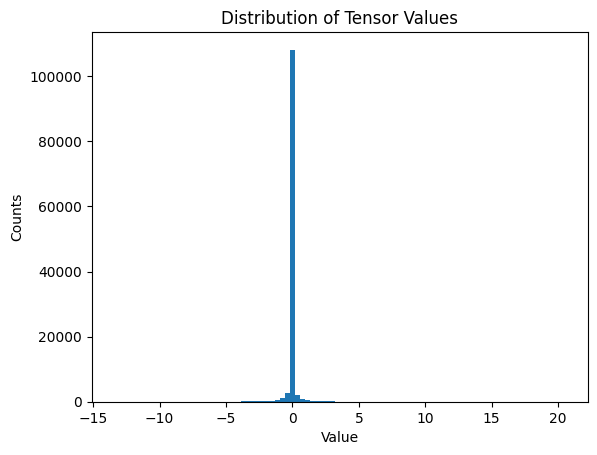

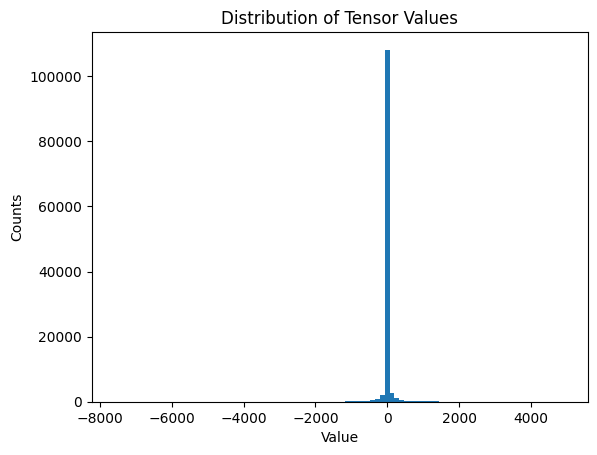

In [47]:
plot_histogram(h_uc.tocsr().data)
plot_histogram((1/norm)*h_uc.tocsr().data)

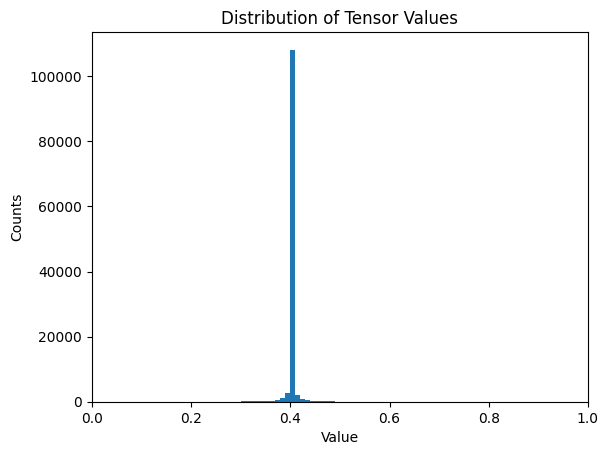

In [5]:
x = h_uc.tocsr().data
x_min = x.min()
x_max = x.max()
x_norm = (x - x_min) / (x_max - x_min)

plot_histogram(x_norm)

In [6]:
#Standarization:
mean = x.mean()
std = x.std()
x_standardized = (h_uc - mean) / (std)
# plot_histogram(x_standardized)

In [11]:
h_uc.tocsr().data

array([-1.46455097e+01, -1.26751269e+01, -5.55662400e-02, ...,
        2.28574531e-05, -1.78419160e-04,  8.69655762e-05])

In [9]:
x_standardized.tocsr().data

array([-23.01884071, -19.91829559,  -0.06047047, ...,   0.02700315,
         0.02668642,   0.02710402])

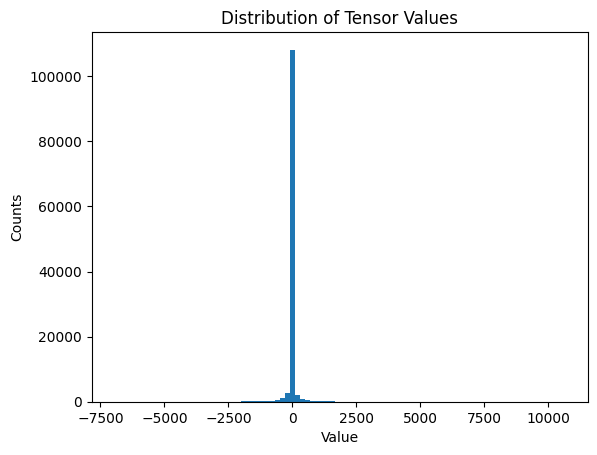

In [52]:
#Robutst scaler

import numpy as np

q1 = np.quantile(x, 0.25)
q3 = np.quantile(x, 0.75)
iqr = q3 - q1 + 1e-8
x_robust = (x - np.median(x)) / iqr
plot_histogram(x_robust)

In [12]:
h_uc.Hk([0,0,0], gauge='cell')

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10100 stored elements and shape (104, 104)>